
<!-- ### 1) LoRA-XS Training with Rank Masking

LoRA-XS enables training multiple models of different sizes simultaneously, achieving similar accuracy compared to training models separately. We used a rank masking technique to train 25x25 parameter matrices. At each step, a parameter \( k \) was selected within the range \([15, 25]\), and elements outside the upper-left \( k \times k \) submatrix were masked. With this method, we trained 11 models simultaneously.

The task was evaluated on the **SST2** benchmark.

The results show that even with rank masking, LoRA-XS achieved comparable performance to models trained separately. A detailed table of accuracy results for different rank values is provided below:

| Rank | Accuracy | Accuracy (no masking) |
|------|----------|-----------------------|
| 15   | 95.64 ± 0.21 | |
| 16   | 95.64 ± 0.22 | 95.87 ± 0.24 |
| 17   | 95.76 ± 0.20 | |
| 18   | 95.64 ± 0.23 | |
| 19   | 95.87 ± 0.21 | |
| 20   | 95.87 ± 0.26 | 95.87 ± 0.28 |
| 21   | 95.76 ± 0.15 | |
| 22   | 95.76 ± 0.05 | |
| 23   | 95.64 ± 0.17 | |
| 24   | 95.64 ± 0.10 | |
| 25   | 95.76 ± 0.21 | 96.33 ± 0.15 |
| **Max** | **95.99 ± 0.17** | **96.33 ± 0.15** | -->


## Adaptive Rank Allocation

This section outlines the development and implementation of an adaptive algorithm for rank allocation in weight matrices under a constrained memory budget. The approach employs a trainable parameter `w` for each weight matrix to determine its rank. For `N` trainable matrices `A1, A2, ..., An`, corresponding rank allocation weights `w1, w2, ..., wn` are assigned.  

Initially, the rank values are continuous, and masks applied to the weight matrices are non-discrete. Through training, the rank allocation stabilizes, and the masks transition to discrete values, enabling adaptive rank allocation.


### Przykładowa implementacja części składowych algorytmu

In [1]:
import torch
import numpy as np

In [2]:
# globalna pamięć
M=100
# ilość macierzy
N=3
# zakres dla macierzy
rank_min=4 
rank_max=8

In [3]:
# funkcja która alokuje pamięć w zależności od parametrów $w$ 
# potencjalnie może przekroczyć zakres rank_max, ale to nam nie szkodzi

def memory_allocation(w,rank_min):
    N=len(w)
    return rank_min**2+(M-N*rank_min**2)*torch.softmax(w,dim=0)

def rank_allocation(w,rank_min):
    N=len(w)
    return torch.sqrt(rank_min**2+(M-N*rank_min**2)*torch.softmax(w,dim=0))


#### Alokacja rzędów wyznaczona parametrem w:

In [4]:
w=torch.randn(N)
print(w)
rank_allocation(w,rank_min)

tensor([-1.0911,  0.1216,  0.2257])


tensor([4.7354, 6.1321, 6.3224])

In [5]:
import torch
import matplotlib.pyplot as plt

def matrix_mask(p, rank_min, rank_max, A):
    # Rozmiar macierzy A
    N = A.size(0)  # Zakładamy, że A jest macierzą NxN

    # Inicjalizacja macierzy wynikowej
    MA = torch.zeros(N, N)

    # Generowanie i sumowanie masek
    for i in range(rank_min, rank_max+1):  # Zakres od rank_min do rank_max (włącznie)
        tensor = torch.zeros(N, N)
        tensor[:i, :i] = 1  # Maska KxK dla aktualnego i
        MA += p[i - rank_min] *  tensor
    
    return MA

def visualize_matrix(matrix, title="Matrix Visualization"):
    plt.figure(figsize=(6, 6))
    # Ustawienie zakresu wartości vmin=0 (biały), vmax=max(matrix) (czarny)
    plt.imshow(matrix, cmap="gray_r", interpolation="none", vmin=0, vmax=matrix.max())
    plt.colorbar(label="Value")

    # Ustawienia etykiet osi
    num_rows, num_cols = matrix.shape
    plt.xticks(ticks=range(num_cols), labels=range(num_cols))
    plt.yticks(ticks=range(num_rows), labels=range(num_rows))
    
    plt.title(title)
    plt.xlabel("Columns (Index)")
    plt.ylabel("Rows (Index)")
    plt.show()



In [6]:
# s to jest parametr
# alfa - przemnazamy wejscie, tau ile gumbela dodajemy, na raize domyślne=0
def prob_dist(s,rank_min,rank_max,alfa,tau=0):
    logits=-alfa*torch.log(1+(s-torch.arange(rank_min,rank_max+1))**2)
    gumbel_dist = torch.distributions.Gumbel(0,1)
    gumbel_vector = gumbel_dist.sample((rank_max+1-rank_min,))
    
    return torch.softmax(logits+tau*gumbel_vector,dim=0)

def matrix_soft(s, rank_min, rank_max, alfa,tau=0):
    A = torch.ones(rank_max, rank_max)  
    p=prob_dist(s,rank_min,rank_max,alfa,tau)
    plt.plot(np.arange(rank_min,rank_max+1),prob_dist(s,rank_min,rank_max,alfa).numpy())
    plt.show()
    return(matrix_mask(p, rank_min, rank_max, A))

# Different alphas visualization

alfa=0.01


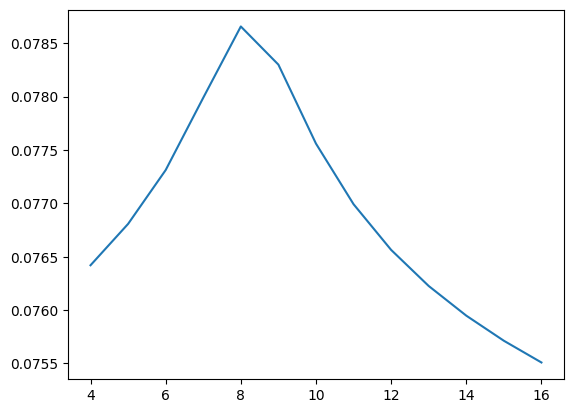

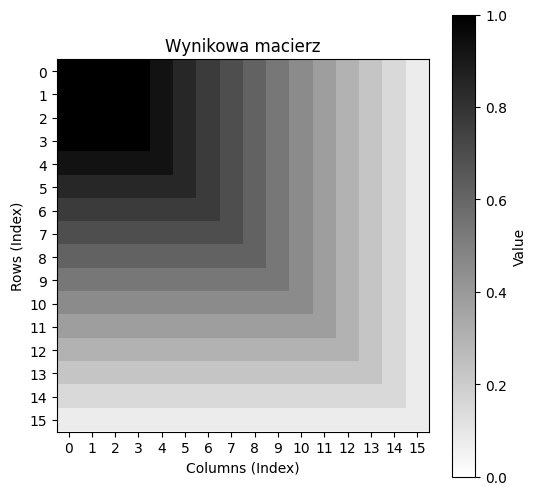

alfa=0.1


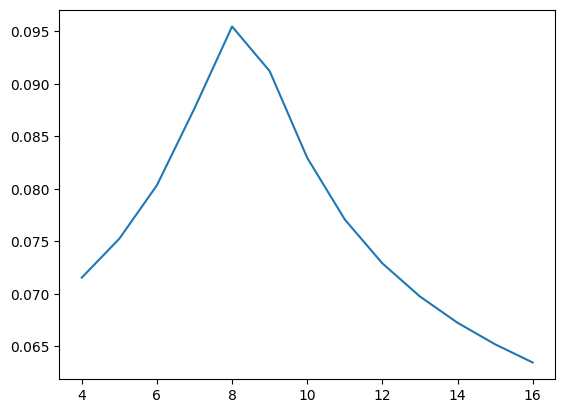

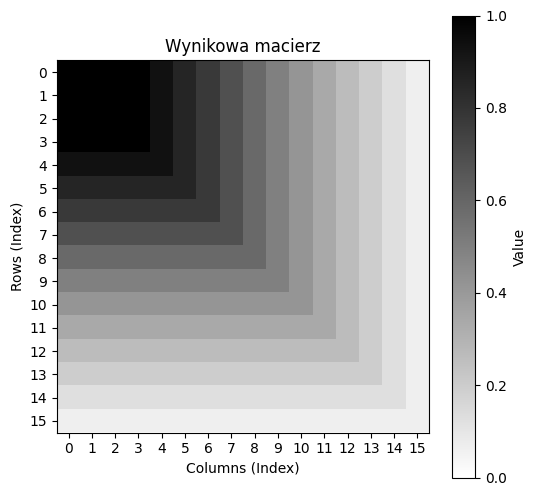

alfa=5


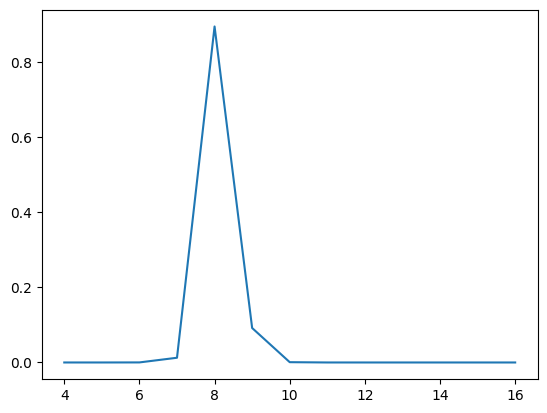

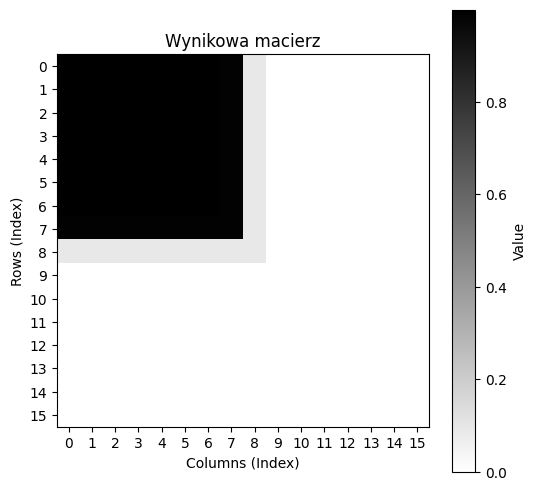

alfa=10


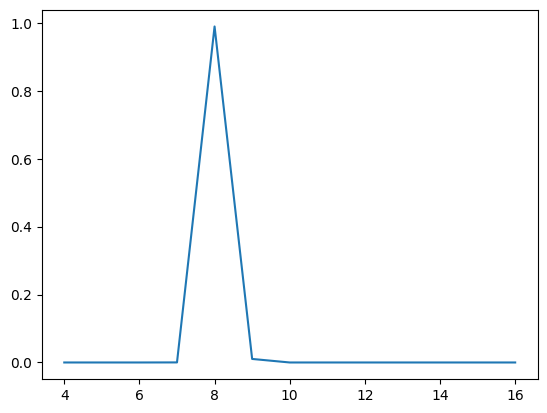

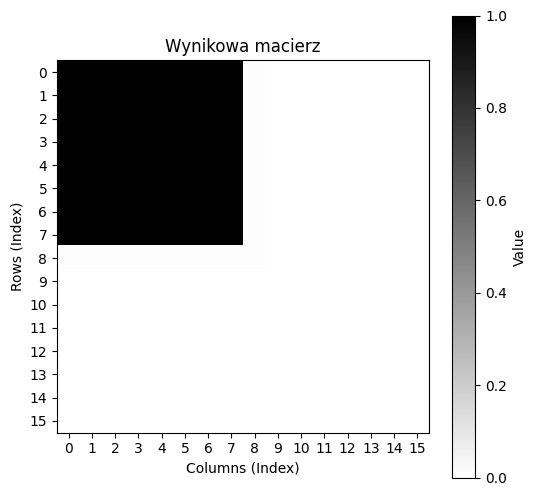

In [42]:
# Obliczenie wynikowej macierzy
# Przykład użycia
rank_min = 4
rank_max = 16
s=8.2

# sterujemy parametrami, jak duże alfa (typu 5), model się dyskretyzuje
# jak alfa=0.1, mamy rozbicie na całą przestrzeń 

#alfa=5
for alfa in [0.01,0.1,5, 10]:
   print(f'{alfa=}')
   result = matrix_soft(s, rank_min, rank_max, alfa)
   # Wizualizacja macierzy
   visualize_matrix(result.numpy(), title="Wynikowa macierz")

## Choosing optimal alpha

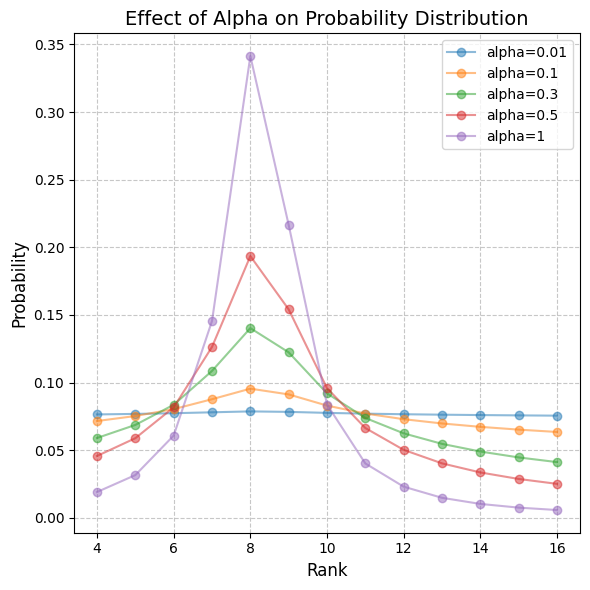

In [ ]:
import matplotlib.pyplot as plt

# Define parameters
rank_min = 4
rank_max = 16
s = 8.2
alpha_values = [0.01, 0.1,0.3, 0.5, 1]

# Create figure and axis
plt.figure(figsize=(6, 6))

# Calculate and plot probability distributions for each alpha
for alpha in alpha_values:
   probs = prob_dist(s, rank_min, rank_max, alpha).numpy()
   plt.plot(np.arange(rank_min, rank_max+1), probs, marker='o', label=f'alpha={alpha}', alpha=0.5)

# Customize the plot
plt.title('Effect of Alpha on Probability Distribution', fontsize=14)
plt.xlabel('Rank', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

Alpha=0.01 - same probability for each of the ranks everywhere, the initial rank allocation weight has no meaning

Alpha=0.1 - slight advantage for the rank allocation weight and nearest 1-2 ranks on both sides

Alpha=0.3 - noticable advantage for the rank allocation weight and nearest 1-2 ranks on both sides and slight disadvantage for the furthest ranks


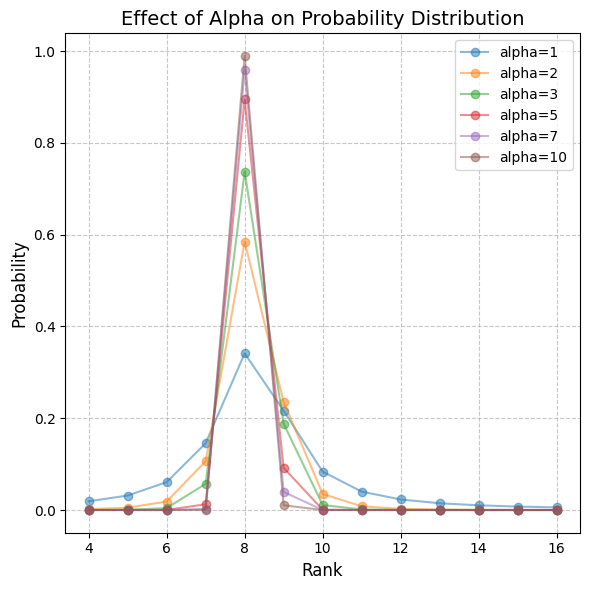

In [41]:
alpha_values = [1,2,3, 5, 7, 10]
plt.figure(figsize=(6, 6))

# Calculate and plot probability distributions for each alpha
for alpha in alpha_values:
   probs = prob_dist(s, rank_min, rank_max, alpha).numpy()
   plt.plot(np.arange(rank_min, rank_max+1), probs, marker='o', label=f'alpha={alpha}', alpha=0.5)

# Customize the plot
plt.title('Effect of Alpha on Probability Distribution', fontsize=14)
plt.xlabel('Rank', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

Alpha=3 around 0.75 probability for the chosen rank, nearest 2 ranks have 0.2, 0.1 probability

Alpha=5 around 0.9 probability for the chosen rank, nearset 2 ranks have less than 0.1 probability

Alpha=10 almost 1 probability for the chosen rank

